# Genetic Algorithm for solving TSP
TSP: Traveling Salesman Problem 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create a Weighted Graph
N = 10 # number of nodes
# A fully connected graph 
# assign an edge weights in [1, 100)
G = {}
for i in range(N):
    for j in range(i+1, N):
        G[(i,j)] = np.random.randint(1, 100)

In [3]:
def get_edge_weight(G, edge):
    if edge[0] > edge[1]:
        edge = edge[::-1] # swap
    if G.get(edge):
        return G[edge]
    else:
        return np.Inf
        

In [4]:
def get_path_cost(G, path):
    # add the edge weights
    # note: come back to the first node
    return sum([get_edge_weight(G, (path[i-1], path[i])) for i in range(len(path))])

In [5]:
def get_fitness(path_costs):
    # simply subtract from the maximum cost
    m = max(path_costs)
    return np.array([m-x for x in path_costs])

In [9]:
# parameters
popsize = 20
pmutate = 0.1
pcross = 0.9

In [10]:
def select(fitness):
    '''roulette wheel selection given finess values
    fitness values should be all non-negative
    '''
    rrand = np.random.sample() * np.sum(fitness)
    return np.where(np.cumsum(fitness) >= rrand)[0][0]

In [11]:
def mutate(path, pmutate, method='swap'):
    '''
    perform mutation on a chromosome
    path: chromosome to be mutated
    pmutate: probability of mutation
    method: mutation method (swap/insertion)
    '''
    # no mutation with (1-pmutate) probability
    if np.random.rand() > pmutate:
        return path
    # otherwise take a deep copy & mutate
    path = list(path)
    # choose a position to swap with the next allele
    loci = np.random.randint(0, len(path))
    if method == 'swap':
        locj = loci + 1 if (loci+1) < len(path) else 0
    else:
        locj = np.random.randint(0, len(path))
    # swap the values at loci & locj
    temp = path[loci]
    path[loci] = path[locj]
    path[locj] = temp
    return path

In [12]:
def pm_crossover(path1, path2, loci, locj):
    '''
    partially mapped crossover between path1 & path2
    at locations [loci, locj]
    '''
    path = list(path2)
    # copy the partial area from path1
    path[loci: locj] = path1[loci: locj]
    # find missing elements in path
    missing = list(set(range(len(path))) - set(path))
    # randomly shuffle missing values
    np.random.shuffle(missing)
    # remove duplicates from path 
    k = 0
    for i in range(len(path)):
        if i >= loci and i < locj:
            continue
        # check for duplication
        rest_path = list(path[:i]) + list(path[i+1:])
        # create a dictionary for faster search
        d = {x:1 for x in rest_path}
        if path[i] in d:
            # duplicate element
            # print('duplicate: %d at %d' %(path[i],i))
            path[i] = missing[k]
            k += 1
    return np.array(path)
        

In [13]:
def order_crossover(path1, path2, loci, locj):
    '''
    Order crossover between path1 & path2
    at locations [loci, locj]
    '''
    # initialize a path with all -1
    path = [-1 for i in range(len(path1))]
    # copy the partial area from path1
    path[loci: locj] = path1[loci: locj]
    # now copy from path2 & ignore duplicates in order
    j = locj if locj < len(path) else 0
    rest_ind = list(range(locj, len(path))) + list(range(locj))
    for i in rest_ind:
        if path2[i] not in path:
            # copy to path
            path[j] = path2[i]
            j += 1
            if j >= len(path):
                j = 0
    
    return np.array(path)
        

In [14]:
def crossover(path1, path2, pcross, method='ox'):
    '''
    perform crossover of two given chromosomes path1 & path2
    pcross is the probability of crossover
    method can be 'ox' (order crossover) or pmx (partially mapped crossover)
    '''
    # no crossover with (1-pcross) probability
    if np.random.rand() > pcross:
        return np.copy(path1), np.copy(path2)
    
    # two-point crossover; sample two positions to copy from path1 to path2
    loci = np.random.randint(len(path1))
    locj = np.random.randint(len(path2))
    if locj < loci:
        # swap
        temp = loci
        loci = locj
        locj = temp
    # select method
    if method == 'ox':
        newp1 = order_crossover(path2, path1, loci, locj)
        newp2 = order_crossover(path1, path2, loci, locj)
    else:
        newp1 = pm_crossover(path2, path1, loci, locj)
        newp2 = pm_crossover(path1, path2, loci, locj)
        
    return newp1, newp2

In [15]:
def generation(pop, pcross, pmutate, mtype='swap', ctype='ox'):
    # get the next generation of population
    newpop = []
    # compute fitness values of current population
    path_costs = np.array([get_path_cost(G, path) for path in pop])
    fitness = get_fitness(path_costs)
    for i in range(len(pop)//2):
        m1 = select(fitness)
        m2 = select(fitness)
        p1 = pop[m1]
        p2 = pop[m2]
        # apply mutation to both selections
        p1 = mutate(p1, pmutate, method=mtype)
        p2 = mutate(p2, pmutate, method=mtype)
        # perform crossover
        p1, p2 = crossover(p1, p2, pcross, method=ctype)
        # append to the new population
        newpop.append(p1)
        newpop.append(p2)

    return np.array(newpop)

In [16]:
def plot_all(max_costs, avg_costs, min_costs):
    max1 = np.max(max_costs)
    min1 = np.min(min_costs)
    max_costs = (max1 - max_costs)/(max1 - min1)
    min_costs = (max1 - min_costs)/(max1 - min1)
    avg_costs = (max1 - avg_costs)/(max1 - min1)
    
    plt.plot(range(ngen+1), max_costs, 'r', label="min fitness")
    plt.plot(range(ngen+1), min_costs, 'g', label="max fitness")
    plt.plot(range(ngen+1), avg_costs, 'b', label="avg fitness")
    plt.xlabel('# generation')
    plt.ylabel('Fitness value')
    plt.show()

In [17]:
def run_ga_tsp(G, N, ngen, popsize, pcross, pmutate, mtype='swap', ctype='ox'):
    """
    Run Genetic Algorithm for the Traveling Salesman Problem
    G: Edge weight graph
    N: Number of nodes in G
    ngen: Number of generations to run the GA
    popsize: population size
    pcross: cross-over probability
    pmutate: mutation probability
    mtype: type of mutation (swap or insertion)
    ctype: type of crossover (either 'ox' (order crossover) or pmx (partially mapped crossover))
    """
    max_costs = []
    min_costs = []
    avg_costs = []
    # initialize a population
    pop = np.array([np.random.permutation(range(N)) for i in range(popsize)])
    # find the initial path costs
    path_costs = np.array([get_path_cost(G, path) for path in pop])
    max_costs.append(np.max(path_costs))
    min_costs.append(np.min(path_costs))
    avg_costs.append(np.mean(path_costs))
    
    for igen in range(ngen):
        pop = generation(pop, pcross, pmutate, mtype, ctype)
        # find updated path costs
        path_costs = np.array([get_path_cost(G, path) for path in pop])
        max_costs.append(np.max(path_costs))
        min_costs.append(np.min(path_costs))
        avg_costs.append(np.mean(path_costs))
    
    plot_all(max_costs, avg_costs, min_costs)
    print('Best path cost = %d'%(min_costs[-1]))

## Experiments: Graph size = 10

In [22]:
# parameters
popsize = 20
pmutate = 0.1
pcross = 0.9
ngen = 100


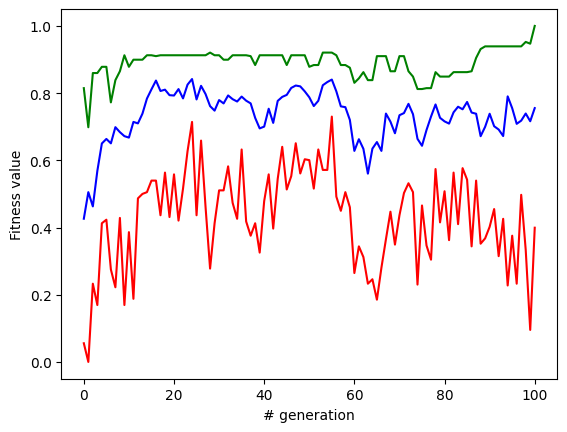

Best path cost = 207


In [24]:
run_ga_tsp(G, N, ngen, popsize, pcross, pmutate, mtype='swap', ctype='ox')

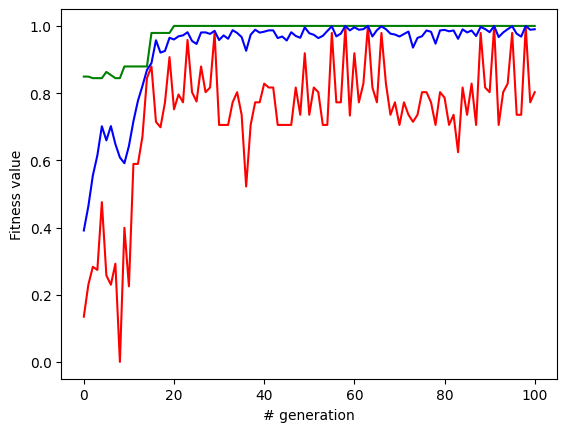

Best path cost = 210


In [25]:
run_ga_tsp(G, N, ngen, popsize, pcross, pmutate, mtype='swap', ctype='pmx')

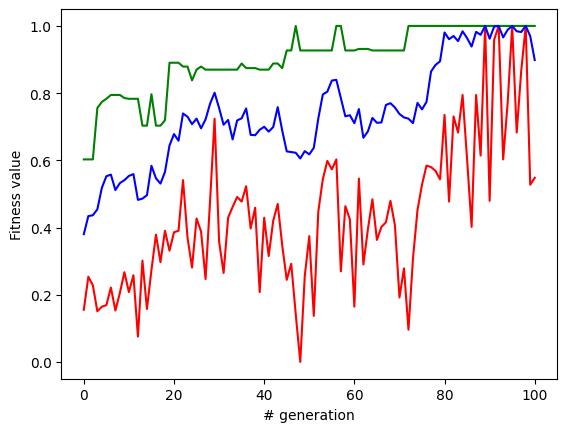

Best path cost = 180


In [26]:
run_ga_tsp(G, N, ngen, popsize, pcross, pmutate, mtype='insertion', ctype='ox')

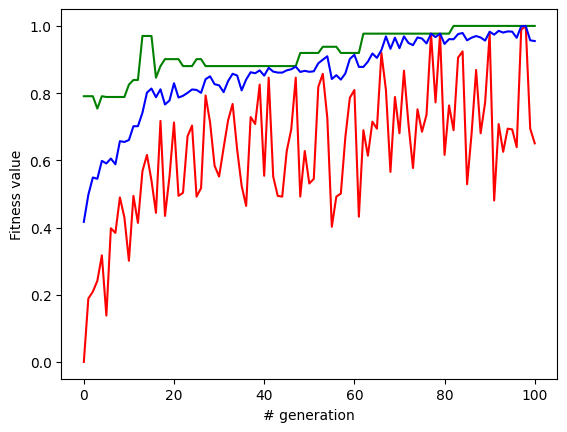

Best path cost = 210


In [27]:
run_ga_tsp(G, N, ngen, popsize, pcross, pmutate, mtype='insertion', ctype='pmx')

## Experiments: Graph size = 50

In [281]:
# Create a Weighted Graph
N = 50 # number of nodes
# A fully connected graph 
# assign an edge weights in [1, 100)
G = {}
for i in range(N):
    for j in range(i+1, N):
        G[(i,j)] = np.random.randint(1, 100)

In [288]:
# parameters
popsize = 20
pmutate = 0.1
pcross = 0.9
ngen = 200

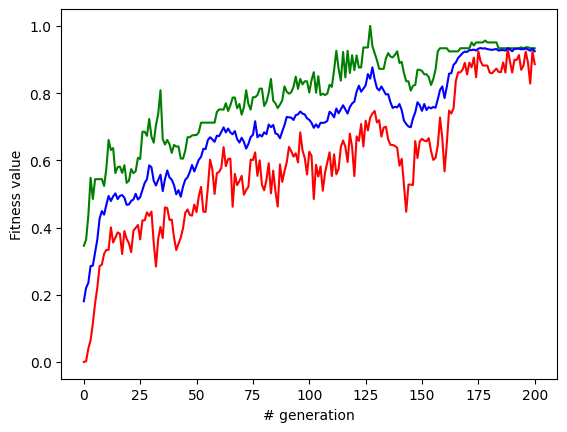

Best path cost = 1218


In [289]:
run_ga_tsp(G, N, ngen, popsize, pcross, pmutate, mtype='swap', ctype='ox')

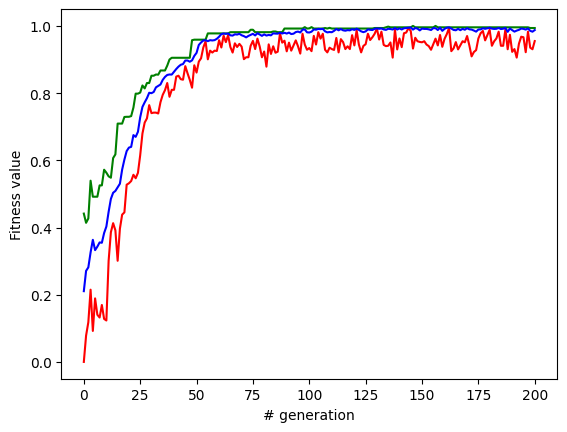

Best path cost = 1028


In [290]:
run_ga_tsp(G, N, ngen, popsize, pcross, pmutate, mtype='swap', ctype='pmx')

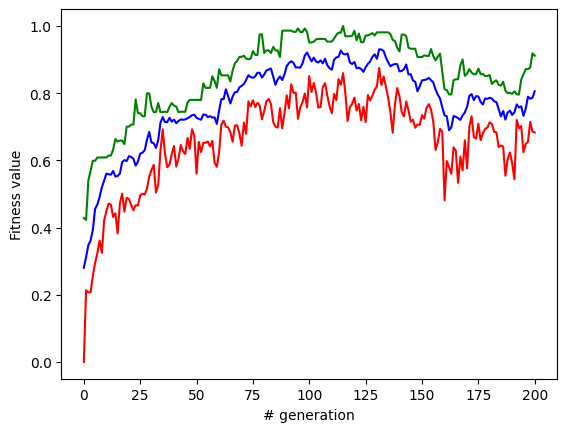

Best path cost = 1220


In [291]:
run_ga_tsp(G, N, ngen, popsize, pcross, pmutate, mtype='insertion', ctype='ox')

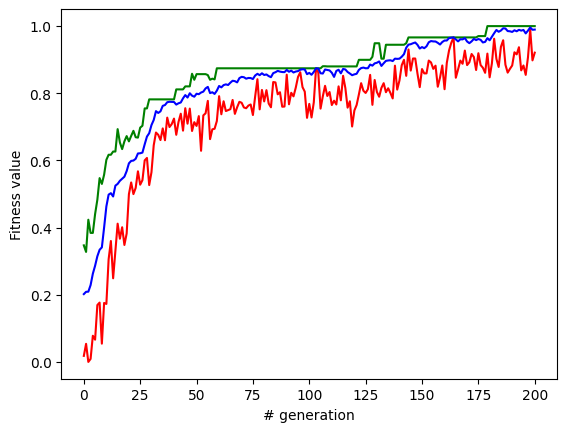

Best path cost = 1093


In [292]:
run_ga_tsp(G, N, ngen, popsize, pcross, pmutate, mtype='insertion', ctype='pmx')

## Experiments: Graph size = 100

In [293]:
# Create a Weighted Graph
N = 100 # number of nodes
# A fully connected graph 
# assign an edge weights in [1, 100)
G = {}
for i in range(N):
    for j in range(i+1, N):
        G[(i,j)] = np.random.randint(1, 100)

In [294]:
# parameters
popsize = 20
pmutate = 0.1
pcross = 0.9
ngen = 500

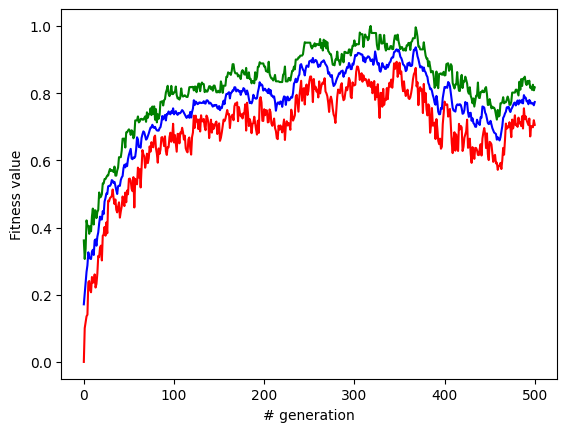

Best path cost = 2652


In [295]:
run_ga_tsp(G, N, ngen, popsize, pcross, pmutate, mtype='swap', ctype='ox')

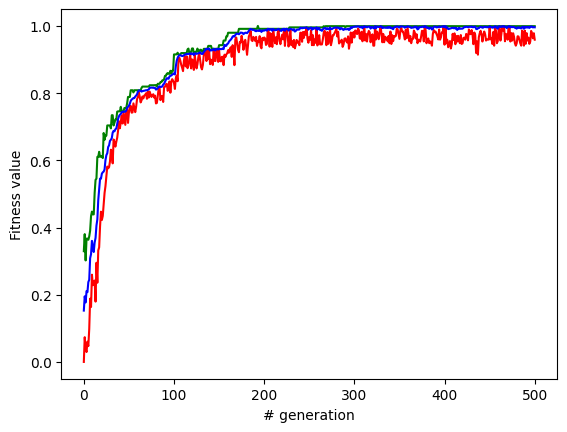

Best path cost = 2733


In [296]:
run_ga_tsp(G, N, ngen, popsize, pcross, pmutate, mtype='swap', ctype='pmx')

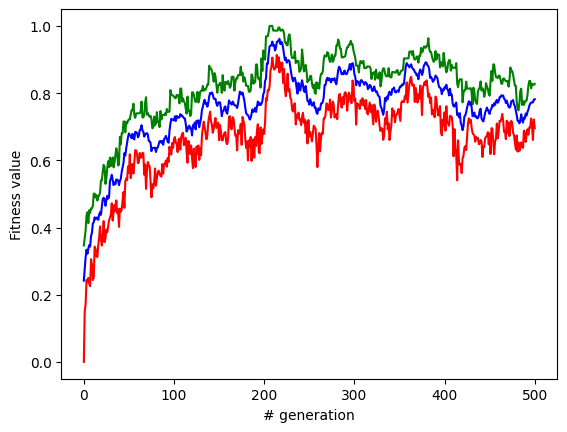

Best path cost = 2830


In [297]:
run_ga_tsp(G, N, ngen, popsize, pcross, pmutate, mtype='insertion', ctype='ox')

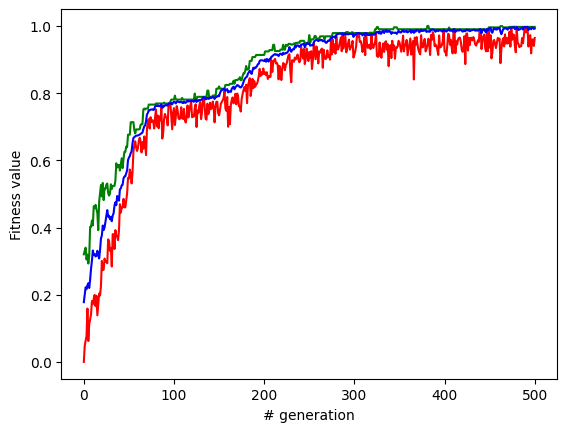

Best path cost = 2197


In [298]:
run_ga_tsp(G, N, ngen, popsize, pcross, pmutate, mtype='insertion', ctype='pmx')